In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import joblib
from tqdm import tqdm
import pandas as pd
import argparse
import os
from scipy.stats import ortho_group

In [2]:
from main import weighted_l2, decode, PSNR, plot_data, load_ecg, load_train_ecg, load_test_ecg, create_pulse
max_signal_length = 100 # used in load_train_ecg and load_test_ecg to keep an integer multiple of patch_size number of samples  

In [3]:
# default values
# cnt is the number of plots to be saved for each (n_components, n_train, patch_size) tuple 
n_train, n_test, n_components, cnt = 10000, 1000, 5, 5
n_init, d, to_train, use_mat = 5, 30, True, False # d is the patch size

# for pulse
num_peaks = d//10
peak_width = 10

folder_name = 'results/n_components=%d,n_train=%d,patch_size=%d/' % (n_components, n_train, d)

In [4]:
def generate_covariance_matrices(n_components, d):
    ans = []
    for i in range(n_components):
        # k = (d//3) * 2 # something lesser than d
        # W = np.random.rand(d,k)
        # S = (W @ W.transpose()) + np.diag(np.random.rand(1,d) * 0.01)
        # S = np.diag(1/np.sqrt(np.diag(S))) @ S @ np.diag(1/np.sqrt(np.diag(S)))
        # ans.append(S)
        Q = ortho_group.rvs(d)
        decay = 0.47*(1 + np.random.random())
        eps = 1e-8
        U = np.ones(d,) * (np.random.rand() * 20) + 600
        for j in range(1,d):
            U[j] = max((U[j-1] * decay) + (np.random.rand() * 0.01), eps)
        ans.append(Q @ np.diag(U) @ Q.transpose())
    return np.array(ans)

In [5]:
gen_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

gen_model.weights_ = np.random.rand(n_components,)
gen_model.weights_ /= np.sum(gen_model.weights_)

gen_model.means_ = np.random.rand(n_components, d) * 80
gen_model.covariances_ = generate_covariance_matrices(n_components, d)

[0.07865203 0.30629681 0.24694696 0.32990957 0.03819463]
(5,)
(5, 30)
(5, 30, 30)


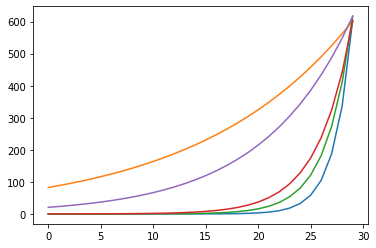

In [6]:
print(gen_model.weights_) # check if no single component gets majority of the weight 
print(gen_model.weights_.shape)
print(gen_model.means_.shape)
print(gen_model.covariances_.shape)

# sanity check of covariance matrix
for i in range(n_components):
    # asserting checks if matrix is positive definite
    assert(np.linalg.det(gen_model.covariances_[i,:,:]) > 0)
    plt.plot(np.linalg.eigvalsh(gen_model.covariances_[i,:,:]))
    
plt.show()

In [7]:
train_data,_ = gen_model.sample(n_train)
train_data.shape

(10000, 30)

In [8]:
# here one assumption is that we know the number of components, however this will have to be varied
model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
model.fit(train_data)

if os.path.isdir(folder_name):
    for f in os.listdir(folder_name):
        if not os.path.isdir(folder_name + f):
            os.remove(folder_name + f)
else:
    os.makedirs(folder_name)

# Save the model as a pickle in a file
joblib.dump(model, folder_name + 'model.pkl')

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True


['results/n_components=5,n_train=10000,patch_size=30/model.pkl']

In [9]:
test_data,_ = gen_model.sample(n_test)
A_ = np.random.binomial(1, 0.5, size=(d, d))

ms = [d*(i+1)//10 for i in range(10)]
psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
val_err, err_std = [], []

for m in tqdm(ms):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    reconstruction = np.empty(test_data.shape)
    patch_err = []
    cnt1 = cnt
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
        # cs example
        if cnt1 > 0:
            plt.plot(x, label='Original', color = "C0")
            plt.plot(x_hat, label='Reconstructed', color = "C1")
            plt.legend()
            plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
            plt.close()
            cnt1 -= 1
        reconstruction[j] = x_hat
    val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    psnr.append(val)
    psnr_min.append(min_val)
    psnr_max.append(max_val)
    psnr_std.append(std_val)
    val_err.append(np.mean(patch_err))
    err_std.append(np.std(patch_err))

print(psnr)
print(psnr_std)
print(val_err)
print(err_std)
plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')

100%|██████████| 10/10 [01:29<00:00,  8.99s/it]


[23.58167723886393, 30.373326283633368, 36.052563414992676, 38.37666878369475, 43.4081863682439, 46.69326101519857, 50.89400191400436, 54.33492391088502, 56.64007511320169, 60.85004307562551]
[8.194625800613261, 4.896595458373416, 4.68265070583671, 5.076311167941359, 5.095889132250019, 5.002660623636205, 5.295696707415824, 5.404533166467884, 5.092871322273042, 5.257774400688657]
[18.975392704315617, 25.31545338382489, 5.880927629200187, 8.596495697708631, 5.129067276631292, 3.9266338037449886, 3.3201699407102354, 2.503797911172992, 1.7134536315010116, 0.8978426605022328]
[19.82497342791997, 38.01016282105712, 4.484549996874701, 7.41003868849535, 4.0679721473058, 2.8399249685209136, 3.111575282245576, 2.590504282835066, 1.431404604138801, 0.809250695028435]


# The following section would be to detect anomalies in the y domain
- we can use val error which is the mean of cross val errors for each measurent length
- let us detect drift based on the following condition

If 20 or more consecutive samples lie outside $E[e_{cv}] + 0.5V[e_{cv}]$ we will conclude that there is a drift in the generating distribution

10it [01:10,  7.01s/it]


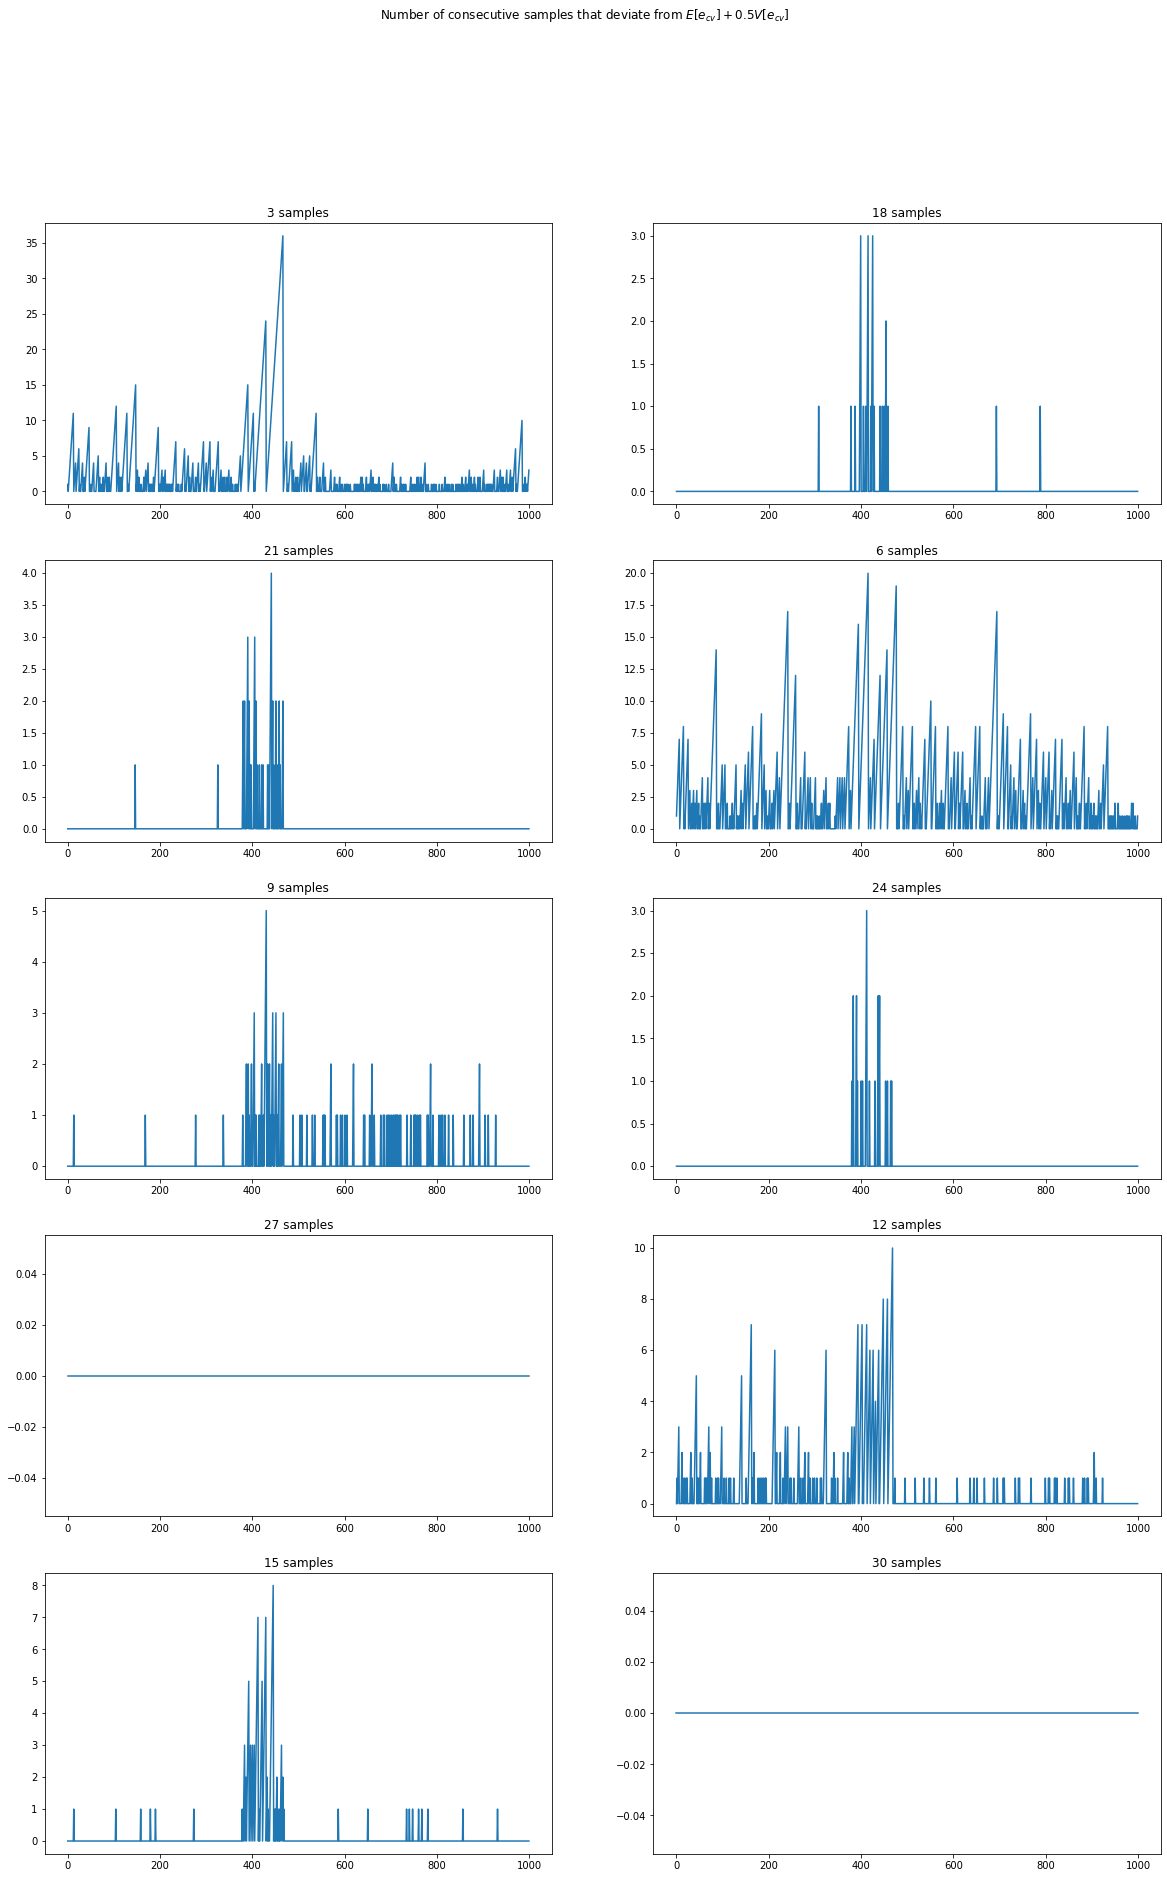

In [10]:
test_data,_ = gen_model.sample(n_test)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Number of consecutive samples that deviate from $E[e_{cv}] + 0.5V[e_{cv}]$")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    dev_counts = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (patch_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            dev_counts.append(deviation_count)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(dev_counts)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

# Observation
We observe that unless the number of measurements is too low (10%), it is very rare that the number of consecutive samples that deviate from <br> $E[e_{cv}] + 0.5V[e_{cv}]$ would be greater than 20. Hence, we can use this as a criteria to detect drift <br>
The following section intends to introduce a drift in the generating distribution intentionally to check whether our criteria was correct

In [11]:
# introduction on drift in the generating distribution
drift_model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
# suppose we are training on n dimensional data

drift_model.weights_ = gen_model.weights_
drift_model.means_ = gen_model.means_ * (np.random.rand()*0.4 + 0.8)
drift_model.covariances_ = generate_covariance_matrices(n_components, d)

10it [01:07,  6.77s/it]


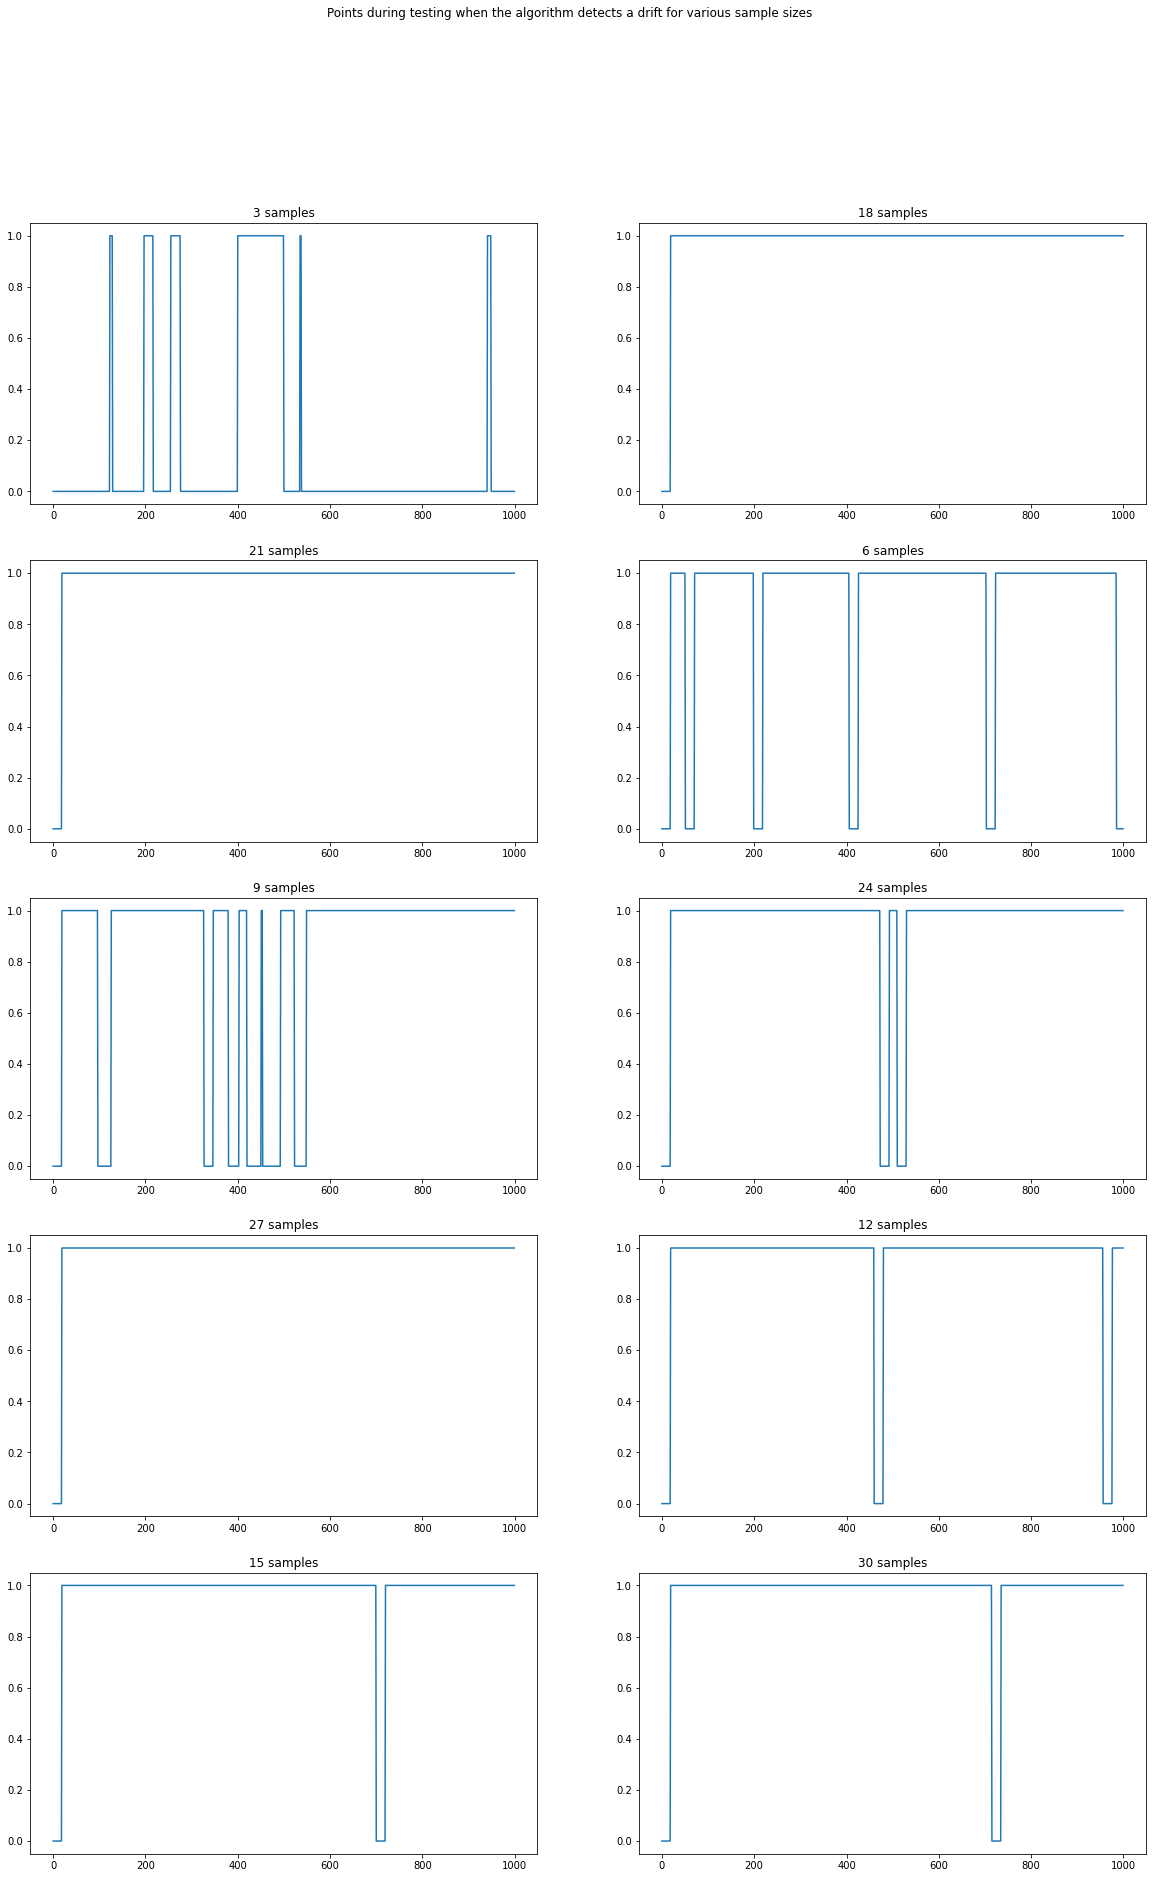

In [13]:
test_data,_ = drift_model.sample(n_test)
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
fig.suptitle("Points during testing when the algorithm detects a drift for various sample sizes")
for iter,m in tqdm(enumerate(ms)):
    if use_mat:
        A = np.load(folder_name + 'mat/%d.npy' % m)
    else:
        A = A_[:m, :]
    mm = (m*4)//5
    flagged = []
    reconstruction = np.empty(test_data.shape)
    deviation_count = 0
    for j in range(len(test_data)):
        x = test_data[j]
        x_hat = np.zeros(x.shape)
        for i in range(x.shape[0]//d):
            y = A @ x[i*d:(i+1)*d]
            x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
            e_cv = np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d])
            if e_cv > (patch_err[i] + 0.5*err_std[i]):
                deviation_count += 1
            else:
                deviation_count = 0
            if(deviation_count >= 20):
                flagged.append(1)
            else:
                flagged.append(0)
        reconstruction[j] = x_hat
    # val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
    ax[iter%5][iter%2].plot(flagged)
    ax[iter%5][iter%2].set_title('%d samples' % m)


plt.show()

Hence we observe that we almost always are able to detect a drift with the given method

In [4]:
# loading aluminium panel data
folder_name_1 = "data/aluminium_data/BASELINE_1(Healthy)/Data_with3dprinter/Data_with_dso/"
folder_name_2 = "data/aluminium_data/rivet_hole_temp/Data_with_dso"
paths_1 = [folder_name_1 + f"Temp{x}/P13.csv" for x in range(20,70,5)]
paths_2 = [folder_name_2 + f"Temp{x}/P13.csv" for x in range(20,70,5)]
# lets only do 13 right now for different temperatures as this will show max variation in case of damages and undamaged measurements

In [14]:
from sklearn.model_selection import train_test_split

def train_GMM_to_data(db, temp,  patch_size = 100, n_components = 10, n_init = 10):
    """
    Takes the entire dataset and splits it into train and test sets. Trains on the training set 
    and returns the model and test set
    """
    d = patch_size
    entries = np.array(db["output"])
    # using overlapping patches for training
    train_data = np.empty((entries.shape[0] - d + 1, d))
    for i in range(entries.shape[0] - d + 1):
        train_data[i] = entries[i:i+d]

    train_data, test_data = train_test_split(train_data, test_size=0.5)
    print(f"train data samples = {train_data.shape[0]}")
    print(f"test data samples = {test_data.shape[0]}")
    # now make test_data non-overlapping
    test_data = np.array([test_data[i, :] for i in range(0, test_data.shape[0], d)] )
    print(f"test data samples (non-overlapping) = {test_data.shape[0]}")

    n_train = train_data.shape[0]
    folder_name = 'results/aluminium_%d/n_components=%d,n_train=%d,patch_size=%d/' % (temp, n_components, n_train, d)

    model = GaussianMixture(n_components=n_components, n_init=n_init, verbose=1, max_iter=200, init_params='random')
    model.fit(train_data)

    if os.path.isdir(folder_name):
        for f in os.listdir(folder_name):
            if not os.path.isdir(folder_name + f):
                os.remove(folder_name + f)
    else:
        os.makedirs(folder_name)

    # Save the model as a pickle in a file
    joblib.dump(model, folder_name + 'model.pkl')
    return (model, n_train, test_data)

In [15]:
def reconstruct_test_data(model, test_data, temp, patch_size, n_components, n_train):
    d = patch_size
    folder_name = 'results/aluminium_%d/n_components=%d,n_train=%d,patch_size=%d/' % (temp, n_components, n_train, d)
    A_ = np.random.binomial(1, 0.5, size=(d, d))
    ms = [d*(i+1)//10 for i in range(10)]
    psnr, psnr_min, psnr_max, psnr_std = [], [], [], []
    val_err, err_std = [], []

    for m in tqdm(ms):
        if use_mat:
            A = np.load(folder_name + 'mat/%d.npy' % m)
        else:
            A = A_[:m, :]
        mm = (m*4)//5
        reconstruction = np.empty(test_data.shape)
        patch_err = []
        cnt1 = cnt
        for j in range(len(test_data)):
            x = test_data[j]
            x_hat = np.zeros(x.shape)
            for i in range(x.shape[0]//d):
                y = A @ x[i*d:(i+1)*d]
                x_hat[i*d:(i+1)*d] = decode(model, A[:mm], y[:mm])
                patch_err.append(np.linalg.norm(y[mm:] - A[mm:] @ x_hat[i*d:(i+1)*d]))
            # cs example
            if cnt1 > 0:
                plt.plot(x, label='Original', color = "C0")
                plt.plot(x_hat, label='Reconstructed', color = "C1")
                plt.legend()
                plt.savefig(folder_name + 'cs_%d_%d.png' % (cnt1, mm))
                plt.close()
                cnt1 -= 1
            reconstruction[j] = x_hat
        val, min_val, max_val, std_val = PSNR(test_data, reconstruction)
        psnr.append(val)
        psnr_min.append(min_val)
        psnr_max.append(max_val)
        psnr_std.append(std_val)
        val_err.append(np.mean(patch_err))
        err_std.append(np.std(patch_err))

    print(psnr)
    print(psnr_std)
    print(val_err)
    print(err_std)
    plot_data([x//5*4 for x in ms], psnr, path=folder_name + 'psnr.png')
    plot_data([x//5*4 for x in ms], val_err, path=folder_name + 'val_err.png', ylabel='Validation error (1e-2)')

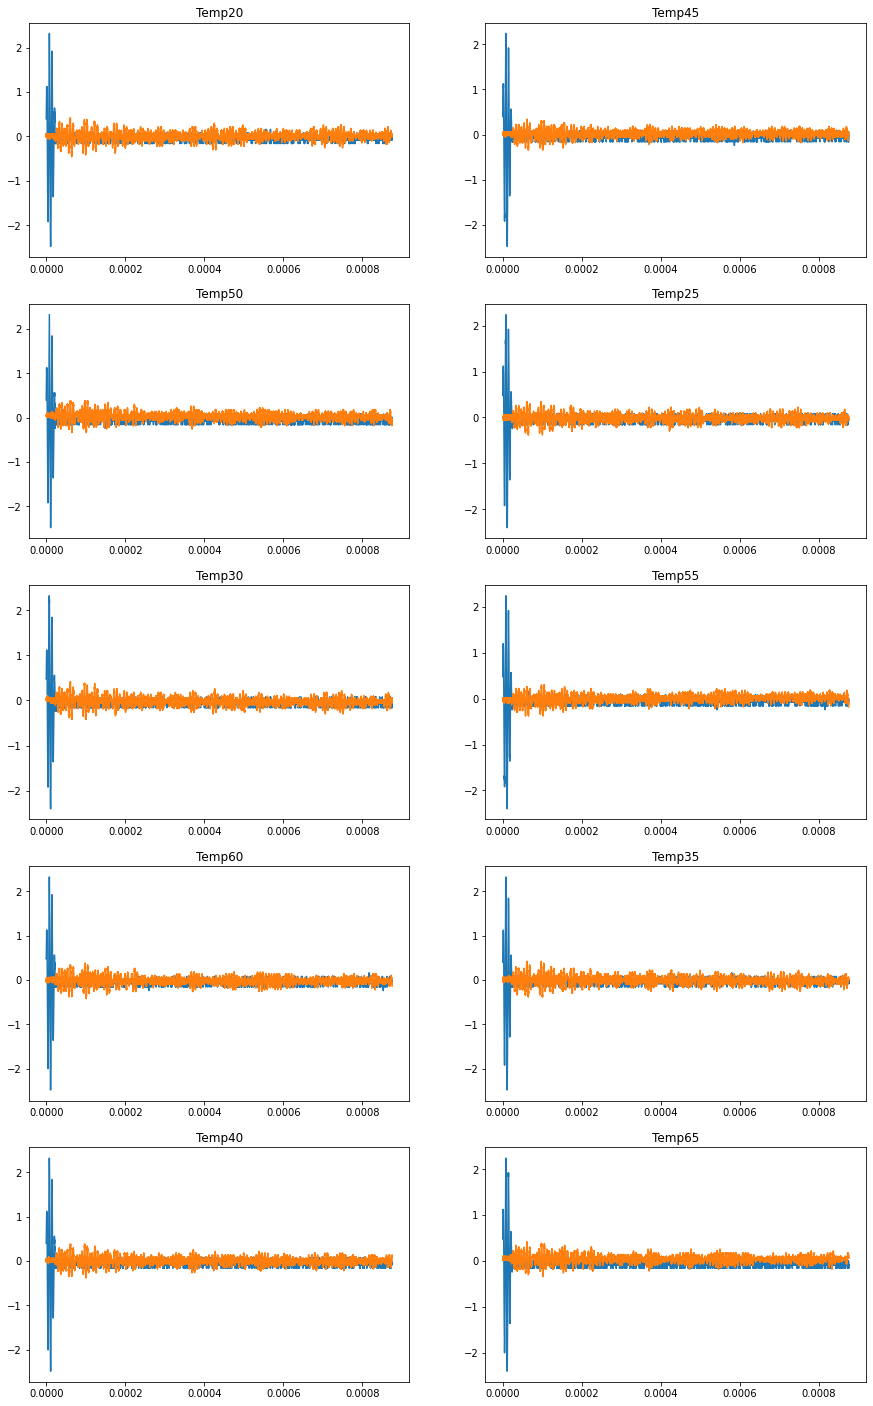

train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
  Iteration 10
Initialization converged: True
Initialization 3
  Iteration 10
Initialization converged: True
Initialization 4
  Iteration 10
Initialization converged: True


100%|██████████| 10/10 [00:43<00:00,  4.30s/it]


[24.948963019203106, 27.847072244881158, 28.607006204979538, 29.214414221641377, 29.73639996075258, 30.35134674479891, 30.86311044289689, 31.649808850454466, 32.55503546889343, 33.87915593696879]
[2.3725000830221648, 1.054025480231253, 0.7604825918589392, 0.8393837047760785, 0.7744622997792493, 0.9108214286383469, 1.0406130821705053, 1.182309893594485, 1.3781521524369635, 1.4684407792049519]
[0.1863106345361899, 0.2852618926372678, 0.30861384310404266, 0.3232699589544519, 0.3526257257108171, 0.3344238970522188, 0.3591282486912167, 0.34858842020083886, 0.33258058359116105, 0.29842429978054175]
[0.08067861432515722, 0.12464008022578657, 0.08130275670777824, 0.08276347646640658, 0.06804257295383237, 0.07509540138054016, 0.07130950297467663, 0.06850366194371503, 0.08400617380870692, 0.06852254462179949]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
In

100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


[25.692542202083327, 27.20685486710033, 28.074201906969755, 28.597309155328336, 29.227167148989793, 29.624815812271365, 30.36321324741931, 31.345332151370744, 32.36451626606615, 33.768574370226546]
[1.4097755412301427, 0.9767873263802559, 0.9065131766725002, 0.8772267417880792, 0.8335081717922309, 0.8958847997353723, 1.0644844302433796, 0.9945899796752227, 1.143241217739875, 1.451781193926021]
[0.2556753390361284, 0.29362146091572144, 0.3121009547722236, 0.35244416519729177, 0.3383745276406639, 0.38601814552055286, 0.3871879518334365, 0.3572781903355427, 0.313667387490949, 0.28775087616600903]
[0.12524290178532435, 0.10475774803587688, 0.08624740580515255, 0.0981780059129494, 0.07216103093906297, 0.07939917859279196, 0.0878321751168906, 0.07201222627026627, 0.057197211196908924, 0.06587144066277614]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
In

100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


[28.57053059310723, 29.694183247678396, 30.54815652093781, 31.00654038505701, 31.5093308467822, 32.14376191865054, 32.6589114674758, 33.48812981240713, 34.61361502570889, 35.887773333090344]
[1.4588955954194869, 1.1582814268160653, 0.881189651000653, 0.9160983589291338, 1.1788290339513472, 1.057216600840512, 1.0533866570822177, 1.0272852228686977, 1.2611054217853248, 1.59498077114151]
[0.22627308207451416, 0.25443695554316054, 0.28700549109565526, 0.3339107041972815, 0.3297885388864146, 0.3292278370792885, 0.36735879449479475, 0.3571643264923621, 0.33632270291769323, 0.30399737342483735]
[0.09985223501703866, 0.10163862490884197, 0.08451526732341032, 0.09393747459240172, 0.08507034335484684, 0.0779766178482121, 0.08537590734734275, 0.06622525498195048, 0.06903023310905233, 0.06332256575839416]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initiali

100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


[28.02940011478607, 29.58951363337901, 30.34348032012, 30.87817081350407, 31.31722411081358, 31.87195638256262, 32.754893518336296, 33.45249758891617, 34.319685293029316, 35.65128156258543]
[1.3153992787041981, 0.9921016579795094, 0.6857158665631973, 0.7523461414428312, 0.9244211351495588, 0.9089243443783771, 0.8302149853150408, 0.9350158305311707, 1.0557379002645157, 1.4124221682613889]
[0.17904737704756066, 0.2760624334402982, 0.3022587785131534, 0.3074649233628631, 0.32057343517090264, 0.3465552363527109, 0.3495729809305301, 0.3332395595649682, 0.3300982786601352, 0.30583104373931036]
[0.09190797513947813, 0.08333215505414097, 0.09088331876576518, 0.08709842232166384, 0.08961665218778221, 0.08890630514103832, 0.07769543130009347, 0.0770515862124178, 0.07066346185787203, 0.06633679704664755]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initiali

100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


[27.224959876984887, 28.665845378370864, 29.367491824970806, 29.879462116537965, 30.41932948471424, 30.91651399900553, 31.480670784163614, 32.19881548533686, 33.40344224546466, 34.63333731194353]
[1.6314012903227282, 0.9493819003475411, 0.7617282696872253, 0.7631901240667791, 0.7819866277499327, 0.6780991748292702, 0.7326816787855865, 0.8980737698671152, 1.0391627214214036, 1.323363947789035]
[0.23502675167549703, 0.2546633503096034, 0.2929317093196122, 0.3361709176083231, 0.3329082881860814, 0.35185486491828794, 0.3659139886189992, 0.35700430841698283, 0.31647022163342603, 0.2847729464368181]
[0.11721851241735616, 0.0922724546112501, 0.09970355912588352, 0.09652506048060512, 0.06993189842881573, 0.07181588234284626, 0.07285582960853557, 0.0805147787560025, 0.04999039333199966, 0.05226475709104192]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Ini

100%|██████████| 10/10 [00:39<00:00,  3.90s/it]


[25.48392026672742, 27.034749012101177, 27.965627335097, 28.574535043147943, 29.07785522204007, 29.763944291484567, 30.20985558766938, 31.083934401074035, 32.07532583164062, 33.336773393645636]
[1.7446586675370233, 1.078253924400235, 0.8641802156216232, 0.7652694728896654, 0.8467099346492257, 0.8776908838696208, 0.9016447681190422, 0.9861984856637236, 1.0915042676034947, 1.215224621502616]
[0.29548188666866493, 0.2865493211663776, 0.28607185878586966, 0.31929970539437963, 0.3564438412733821, 0.3634602104403936, 0.35308833176569937, 0.32972180874828444, 0.3233851861645961, 0.30717150950683725]
[0.15172557511744328, 0.11487162598201042, 0.10887378963664329, 0.09374121391477898, 0.0807913261189088, 0.08106717771635587, 0.08065150659487808, 0.0703214350045093, 0.06935594232058641, 0.07012376422416387]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Init

100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


[25.90719637252671, 27.84053045926821, 28.310552642572357, 28.77420348330776, 29.225197230188943, 29.823390414999206, 30.437339301652255, 31.246568648691042, 32.20751965608824, 33.68776619439341]
[1.600359109282394, 0.7373860237808532, 0.793292767785828, 0.6721723215745085, 0.709529539076699, 0.8224638178390892, 0.7474230071560286, 0.9389651464463118, 1.0850258800483228, 1.4544153099393458]
[0.1717563811631109, 0.2504106321480395, 0.2990256500431574, 0.33050097221133945, 0.352829472957794, 0.34732574229188967, 0.35813218866095514, 0.34652362050312707, 0.3347720969076702, 0.3230052128971987]
[0.09885686329464977, 0.09160024777198846, 0.09709260585441998, 0.08115370499139893, 0.09358583572537592, 0.08469841836349871, 0.07855505476636085, 0.09342038741511505, 0.08019241375283227, 0.08079047160281044]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Init

100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


[26.82571884395453, 27.72806427078792, 28.534533955525, 29.23724589003318, 29.766717612351872, 30.345292060286116, 30.855534418854514, 31.955607598664006, 33.063484872996746, 34.58392959909097]
[1.4219798266522954, 1.2329180550739647, 1.0624990687576534, 1.0121497893179774, 0.9549868525661072, 0.9465749374507343, 1.0304106738999932, 1.233405441723624, 1.3903750902691157, 1.5126942463752242]
[0.17702527448063346, 0.2782269917432065, 0.3255131799754873, 0.3328143007967801, 0.3296036442536263, 0.3626104782120124, 0.38930229186749066, 0.35997179766467347, 0.31677353518405477, 0.28015155298857136]
[0.09792935148639297, 0.11237070058742493, 0.08357026664757027, 0.08985034558398997, 0.07042186529103084, 0.07739148918832832, 0.07208082427739283, 0.08466705472164436, 0.06793912058361636, 0.05283688425337645]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
In

100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


[26.747118486486908, 29.454047163279142, 30.22934581656025, 30.82552361680381, 31.387818620329153, 31.97224970456799, 32.676672236966134, 33.58640794639053, 34.5383137672855, 35.81095549244298]
[2.680104787272198, 0.7277870798368488, 0.8359607394668821, 0.8214052230297916, 0.9104448528329219, 0.8856088990966013, 0.9097075728735304, 1.091676598640831, 1.3371141870700378, 1.6676944544344336]
[0.23715747844578788, 0.246912940532344, 0.2992366656491611, 0.33916856345091817, 0.32481105377121994, 0.33988734636146484, 0.3350648424246461, 0.30637771073368564, 0.31212716888631253, 0.3086807039567688]
[0.13289036457672415, 0.07593089743914845, 0.08619466166097754, 0.09123529033772854, 0.08581699190591544, 0.0751711098611909, 0.07184657331638297, 0.06480327168892747, 0.08034062517550417, 0.0782417058998387]
train data samples = 4325
test data samples = 4325
test data samples (non-overlapping) = 44
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 1
  Iteration 10
Initi

100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


[24.978158076949807, 26.306469509304335, 27.804279100692625, 28.40460972729095, 28.99767406154183, 29.514714643664316, 30.13562451844803, 30.973741215443113, 31.981480478895854, 33.28450704277741]
[2.1083711730831007, 1.6132156379553817, 0.923892819433617, 0.9609004784404996, 1.0116934522331804, 1.1415945776422924, 1.1540836598495983, 1.1413090268537602, 1.223243561735205, 1.1736164884775142]
[0.24272934413965402, 0.3072271924282717, 0.3141132099902478, 0.32692095344046573, 0.3423370802110628, 0.34817334072903044, 0.3505262371321271, 0.33604530995676646, 0.3366249531282696, 0.28480727014147345]
[0.11396187344911347, 0.13451613968052065, 0.07563588494652929, 0.08561785080723108, 0.07417100005199853, 0.08271064635845198, 0.08075574221951509, 0.06995056000650529, 0.07621281850065234, 0.053469522218322345]


In [16]:
import pandas as pd

fig, ax = plt.subplots(len(paths_1)//2, 2, figsize = (15, 25))
for i,path in enumerate(paths_1):
    db = pd.read_csv(path, usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["input"])
    ax[i%(len(paths_1)//2)][i%2].plot(db["time"], db["output"])
    ax[i%(len(paths_1)//2)][i%2].set_title(path[-14:-8])

plt.show()

for i,path in enumerate(paths_1):
    db = pd.read_csv(path, usecols=[3, 4, 10], header = None, names = ["time", "input", "output"])
    db = db[db["time"] > 0]
    model, n_train, test_data = train_GMM_to_data(db, int(path[-10:-8]), 100, 10, 5)
    reconstruct_test_data(model, test_data, int(path[-10:-8]), 100, 10, n_train)